# Anime Analysis by Ben Osborn and OsbornAI

## This project consists of the scraping and creation of a dataset containing information about all anime's listed on MyAnimeList. This data is analysed, and a model is created to predict the anime's rating based on the pages features

### Imports

In [1]:
import requests
from bs4 import BeautifulSoup
from csv import DictWriter
import os
import pandas as pd
import matplotlib.pyplot as plt
import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

### Scraping and dataset creation

#### Parses through the labels from the soup elements

In [2]:
# Change name to clean label
def parseLabel(element):
    string = element.text
    
    split_colens = string.split(':')
    removed_label = split_colens[1:]
    
    for i, label in enumerate(removed_label):
        removed_label[i] = label.replace('\n', '').strip()
    
    joined = " ".join(removed_label)
    
    return joined

#### Parses through the list soup elements

In [3]:
def parseList(element): # Have to check that a tags exist for ever single page and developer
    ret_list = [a.text for a in element.find_all('a')]
    
    return ", ".join(ret_list)

#### Define the field names globally

In [4]:
field_names = ['name_english', 'name_japanese', 'show_type', 'episodes', 'status', 'aired', 'broadcast_time', 'producers', 
               'licensors', 'studios', 'source', 'genres', 'episode_length', 'rating', 'score_and_scorers', 
               'members', 'favorites', 'description']

#### Scrapes the page from the show and returns a row of data

In [5]:
def createRow(url):
    global field_names
    ret_dict = {field_name: '' for field_name in field_names}

    req = requests.get(url)
    soup = BeautifulSoup(req.content, 'html.parser')

    side_panel = soup.find('td', class_='borderClass')
    side_panel_subdiv = side_panel.find('div')
    side_panel_divs = side_panel_subdiv.find_all('div')

    try:
        ret_dict['description'] = soup.find('p', itemprop='description').text

    except Exception as e:
        print(f"Encountered an error '{e}' for description at '{url}'.")

    for panel in side_panel_divs:
        try:
            split = str(panel.text.split(':')[0].strip())

            if split == "English":
                ret_dict['name_english'] = parseLabel(panel)

            if split == "Japanese":
                ret_dict['name_japanese'] = parseLabel(panel)

            if split == "Type":
                ret_dict['show_type'] = parseLabel(panel)

            if split == "Episodes":
                ret_dict['episodes'] = parseLabel(panel)

            if split == "Status":
                ret_dict['status'] = parseLabel(panel)

            if split == "Aired":
                ret_dict['aired'] = parseLabel(panel)

            if split == "Broadcast":
                ret_dict['broadcast_time'] = parseLabel(panel)

            if split == "Producers":
                ret_dict['producers'] = parseList(panel)

            if split == "Licensors":
                ret_dict['licensors'] = parseList(panel)

            if split == "Studios":
                ret_dict['studios'] = parseList(panel)

            if split == "Source":
                ret_dict['source'] = parseLabel(panel)

            if split == "Genres":
                ret_dict['genres'] = parseList(panel)

            if split == "Duration":
                ret_dict['episode_length'] = parseLabel(panel)

            if split == "Rating":
                ret_dict['rating'] = parseLabel(panel).split(' ')[0]

            if split == "Score":
                ret_dict['score_and_scorers'] = ", ".join([part.text for part in panel.find_all('span')][1:])

            if split == "Members":
                ret_dict['members'] = "".join(parseLabel(panel).split(','))

            if split == "Favorites":
                ret_dict['favorites'] = "".join(parseLabel(panel).split(','))

        except Exception as e:
            print(f"Encountered an error '{e}' at '{url}'.")
            
    return ret_dict
    
# createRow("https://myanimelist.net/anime/5114/Fullmetal_Alchemist__Brotherhood")

#### Go through the amount of pages specified then scrape the information for each show, then store them to a CSV file

In [6]:
# Introduce sharding of CSV to this

def genDataset(end_page, csv_filename, start_page=0): # Where resume is the page of which it left off from
    global field_names
    link = ['Unknown']
            
    for i in range(start_page, end_page):
        
        print(f"Scraping page {i}...")

        csv_path = os.path.join(os.getcwd(), 'csv', f'{csv_filename}-{i}.csv')

        with open(csv_path, 'w', newline='') as csvfile:
            writer = DictWriter(csvfile, fieldnames=field_names)
            
            writer.writeheader()

            url_page = f"https://myanimelist.net/topanime.php?limit={i*50}"
            req_list = requests.get(url_page)
            soup_list = BeautifulSoup(req_list.content, 'html.parser')
            shows = soup_list.find_all('tr', class_='ranking-list')

            for show in shows:
                try:
                    link[0] = show.find('a').get('href')
                    data_row = createRow(link[0])
                    writer.writerow(data_row)

                except Exception as e:
                    print(f"Encountered error '{e}' at '{link[0]}'.")
    
    print("Dataset creation complete!")
    
# Testing on a small dataset to begin with
# genDataset(5, 'mal-data-11-13-2020', start_page=3)

### Data handling and cleaning

#### Concatenate CSV files and put them into a data frame

In [7]:
data_path = os.path.join(os.getcwd(), 'csv')

dfs = []
for csv in os.listdir(data_path):
    dfs.append(pd.read_csv(os.path.join(data_path, csv), index_col=0))

df = pd.concat(dfs)

#### Type conversion and data cleanup

In [8]:
df = df[df['episodes'] != 'Unknown']
df['episodes'] = df['episodes'].astype(int)

df['favorites'] = df['favorites'].astype(int)

df['members'] = df['members'].astype(int)

df = df.dropna()

In [9]:
def parseScoreAndScorer(score_and_scorers_raw, position):
    try:
        numerical_version = float(score_and_scorers_raw.split(', ')[position].strip())
        return numerical_version
    except:
        return pd.NaT
    
df['score'] = df['score_and_scorers'].apply(lambda s: parseScoreAndScorer(s, 0)).astype(float)
df['scorer'] = df['score_and_scorers'].apply(lambda s: parseScoreAndScorer(s, 1)).astype(int)
df = df.dropna()
df = df.drop('score_and_scorers', axis=1)

#### Time data parsing

In [10]:
def broadcastParse(broadcast_raw): # This parses through the broadcast time
    broadcast_split = [bc_time.strip() for bc_time in broadcast_raw.split(' at ')]
    if (len(broadcast_split) == 1) or ('Unknown' in broadcast_split):
        return pd.NaT
    broadcast_split[0] = broadcast_split[0][:-1]
    broadcast_split[1] = broadcast_split[1][:5]
    broadcast_string = " ".join(broadcast_split)
    
    return broadcast_string

df['broadcast_time'] = df['broadcast_time'].apply(broadcastParse)
df = df.dropna()
df['broadcast_time'] = pd.to_datetime(df['broadcast_time'], format='%A %H %M')

In [11]:
# This one needs to parse the minutes/hours for the episode length
def timeParse(time_raw):
    time_split = time_raw.split(' ')
    if time_split[1] == 'min.':
        return int(time_split[0])
    elif time_split[1] == 'hr.':
        return int(time_split[0]) * 60 + int(time_split[2]) # This will cause an error if it has different formatting
    
df['episode_length'] = df['episode_length'].apply(timeParse)

In [12]:
def parseAired(aired_raw, position):
    aired_split = aired_raw.split(' to ')
    try:
        aired_parsed = " ".join(aired_split[position].strip().split(", "))
        aired_formatted = str(time.strftime('%d %m %Y', time.strptime(aired_parsed, '%b %d %Y')))
        return aired_formatted
    except:
        return pd.NaT

df['aired_start'] = pd.to_datetime(df['aired'].apply(lambda s: parseAired(s, 0)), format='%d %m %Y')
df['aired_end'] = pd.to_datetime(df['aired'].apply(lambda s: parseAired(s, 1)), format='%d %m %Y')
df = df.dropna()
df = df.drop('aired', axis=1)

In [13]:
df.head()

,name_japanese,show_type,episodes,status,broadcast_time,producers,licensors,studios,source,genres,episode_length,rating,members,favorites,description,score,scorer,aired_start,aired_end
name_english,,,,,,,,,,,,,,,,,,,
Fullmetal Alchemist Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,Finished Airing,1900-01-01 17:00:00,"Aniplex, Square Enix, Mainichi Broadcasting Sy...","Funimation, Aniplex of America",Bones,Manga,"Action, Military, Adventure, Comedy, Drama, Ma...",24,R,2023958,167719,"""In order for something to be obtained, someth...",9.22,1232300,2009-04-05,2010-07-04
Steins;Gate,STEINS;GATE,TV,24,Finished Airing,1900-01-01 02:05:00,"Frontier Works, Media Factory, Movic, AT-X, Ka...",Funimation,White Fox,Visual novel,"Thriller, Sci-Fi",24,PG-13,1635137,139832,The self-proclaimed mad scientist Rintarou Oka...,9.12,884618,2011-04-06,2011-09-14
Gintama Season 4,銀魂°,TV,51,Finished Airing,1900-01-01 18:00:00,"TV Tokyo, Aniplex, Dentsu","Funimation, Crunchyroll",Bandai Namco Pictures,Manga,"Action, Comedy, Historical, Parody, Samurai, S...",24,PG-13,363575,10347,"Gintoki, Shinpachi, and Kagura return as the f...",9.11,126846,2015-04-08,2016-03-30
Hunter x Hunter,HUNTER×HUNTER（ハンター×ハンター）,TV,148,Finished Airing,1900-01-01 10:55:00,"VAP, Nippon Television Network, Shueisha",Viz Media,Madhouse,Manga,"Action, Adventure, Fantasy, Shounen, Super Power",23,PG-13,1457626,130325,Hunter x Hunter is set in a world where Hunter...,9.11,827525,2011-10-02,2014-09-24
Gintama Season 2,銀魂',TV,51,Finished Airing,1900-01-01 18:00:00,"TV Tokyo, Aniplex, Dentsu, Trinity Sound, Mira...",add some,Sunrise,Manga,"Action, Sci-Fi, Comedy, Historical, Parody, Sa...",24,PG-13,336989,6009,"After a one-year hiatus, Shinpachi Shimura ret...",9.08,140502,2011-04-04,2012-03-26


### Data analysis

#### Question 1: What is the highest rated show in consideration with the amount of users?

In [14]:
# To solve this we say the rating is the probability of an anime being good, then we take the Z-scores 
# and we look at the highest Z-score which means it will be the anime that exceeds the average 
# chance of it being good based on its members
good_probability = df['score'].mean() / 10
probabilities = df['score'] / 10
stds = (good_probability * (1 - good_probability) / df['members']) ** 0.5

highest_scored = (probabilities - good_probability) / stds
highest_scored.sort_values(ascending=False)

name_english
Fullmetal Alchemist Brotherhood             273.250752
Steins;Gate                                 209.368885
Hunter x Hunter                             194.256602
Attack on Titan Season 3 Part 2             134.933732
Code Geass Lelouch of the Rebellion R2      113.140528
                                               ...    
My Teen Romantic Comedy SNAFU TOO!          -59.788460
Neon Genesis Evangelion                     -67.332888
My Hero Academia 3                          -67.826381
Re ZERO -Starting Life in Another World-    -79.459756
Toradora!                                   -91.928928
Length: 131, dtype: float64

##### The best anime with the highest score based on its users is Fullmetal Alchemist as it has the highest Z-score above the mean rating based on it's users compared to the others

#### Question 2: What is the most popular genre?

<AxesSubplot:xlabel='genres'>

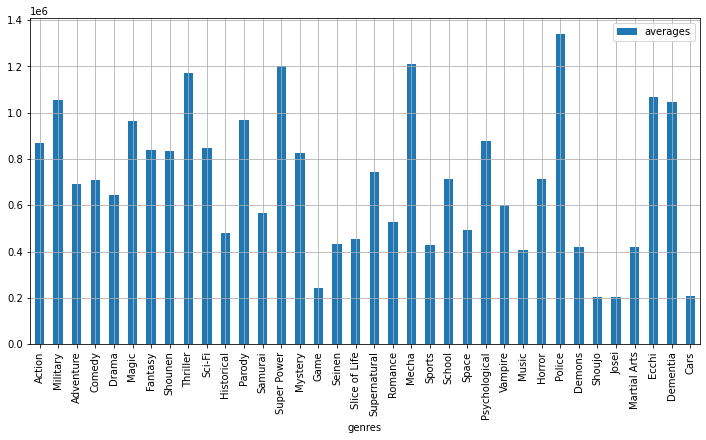

In [16]:
# To do this we are going to have to gather all of the different genre's and then make a new dataframe with these genres
# and then look at the one with the highest memberbase
new_df = df[df['producers'] != 'add some']
new_df = new_df[new_df['licensors'] != 'add some']
new_df = new_df[new_df['genres'] != 'add some']

genres = []
def makeDataList(array_string, data_list):
    split_string = array_string.split(", ")
    for item in split_string:
        if item not in data_list:
            data_list.append(item)

new_df['genres'].apply(lambda s: makeDataList(s, genres))

genre_df = pd.DataFrame()

averages = []
for genre in genres:
    dummy_df = new_df[new_df['genres'].str.contains(genre)]
    average_members = dummy_df['members'].mean()
    averages.append(average_members)

# Now how do I turn this entire row into a new row on the bottom?
genre_df['genres'] = genres
genre_df['averages'] = averages

genre_df.plot.bar(x='genres', y='averages', grid=True)

#### Question 3: What was the best time to air and for how long to get the most viewers?

#### Question 4: What studios have the best ratings with consideration for the amount of users?

#### Question 5: What licensors have the best ratings with consideration for the amount of users?

#### Question 6: What month had the highest average watchers and thus what is the best month to release a show?